### Imports

In [32]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input, Model

In [33]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


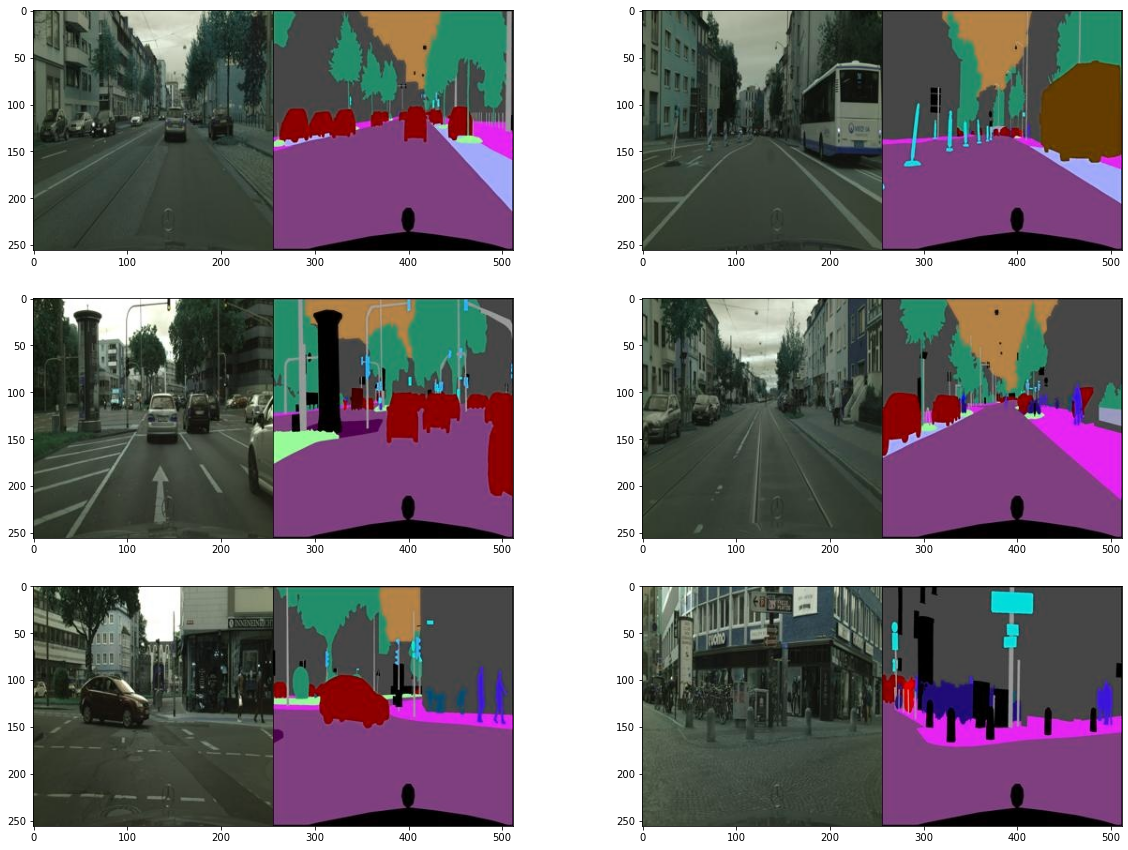

In [34]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [35]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


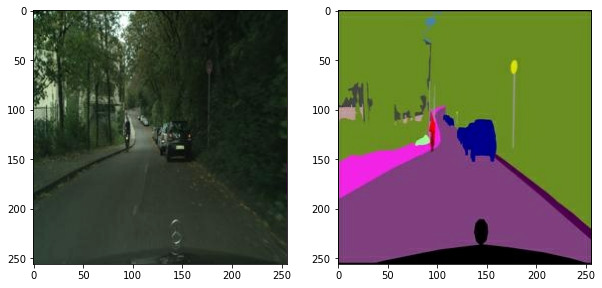

In [36]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [37]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


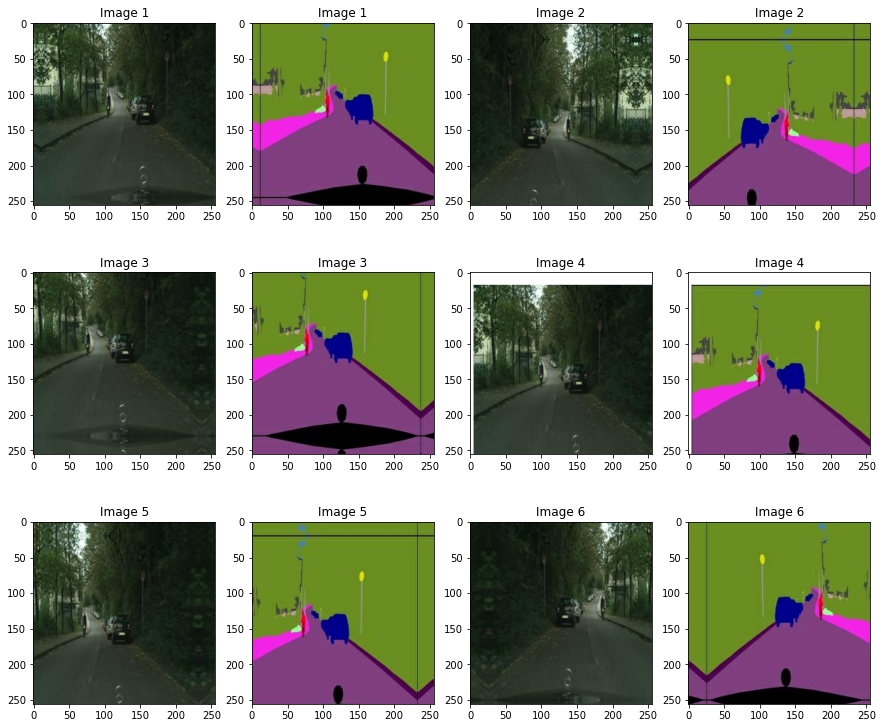

In [38]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

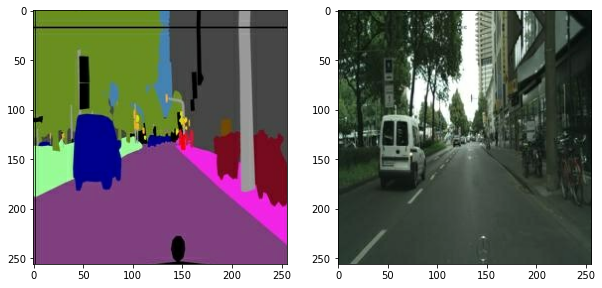

In [39]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return colored, sketch

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### Generator 

#### EncodeBlock, DecodeBlock

In [40]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [41]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [42]:
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_32 (EncodeBlock)   (None, 128, 128, 64) 3072        input_3[0][0]                    
__________________________________________________________________________________________________
encode_block_33 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_32[0][0]            
__________________________________________________________________________________________________
encode_block_34 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_33[0][0]            
____________________________________________________________________________________________

### Discriminator

In [43]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [44]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_85 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [45]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

print("✅")

✅


In [46]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [47]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [48]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [49]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")


EPOCH[1] - STEP[10]                     
Generator_loss:0.8915                     
L1_loss:0.2965                     
Discriminator_loss:1.3394

EPOCH[1] - STEP[20]                     
Generator_loss:0.9058                     
L1_loss:0.2305                     
Discriminator_loss:1.1906

EPOCH[1] - STEP[30]                     
Generator_loss:0.9347                     
L1_loss:0.2121                     
Discriminator_loss:1.4773

EPOCH[1] - STEP[40]                     
Generator_loss:0.8700                     
L1_loss:0.1916                     
Discriminator_loss:1.1673

EPOCH[1] - STEP[50]                     
Generator_loss:1.1355                     
L1_loss:0.1769                     
Discriminator_loss:1.4080

EPOCH[1] - STEP[60]                     
Generator_loss:0.9094                     
L1_loss:0.1934                     
Discriminator_loss:1.2450

EPOCH[1] - STEP[70]                     
Generator_loss:0.9956                     
L1_loss:0.2054                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.5953                     
L1_loss:0.1635                     
Discriminator_loss:1.0037

EPOCH[3] - STEP[80]                     
Generator_loss:2.4266                     
L1_loss:0.2212                     
Discriminator_loss:0.4495

EPOCH[3] - STEP[90]                     
Generator_loss:1.4762                     
L1_loss:0.1860                     
Discriminator_loss:0.5186

EPOCH[3] - STEP[100]                     
Generator_loss:1.6779                     
L1_loss:0.1775                     
Discriminator_loss:0.6122

EPOCH[3] - STEP[110]                     
Generator_loss:1.4257                     
L1_loss:0.1819                     
Discriminator_loss:0.4975

EPOCH[3] - STEP[120]                     
Generator_loss:1.4448                     
L1_loss:0.1795                     
Discriminator_loss:0.4579

EPOCH[3] - STEP[130]                     
Generator_loss:2.1178                     
L1_loss:0.1389                

EPOCH[5] - STEP[130]                     
Generator_loss:1.1186                     
L1_loss:0.1708                     
Discriminator_loss:0.6484

EPOCH[5] - STEP[140]                     
Generator_loss:1.9397                     
L1_loss:0.1715                     
Discriminator_loss:1.4169

EPOCH[5] - STEP[150]                     
Generator_loss:0.6847                     
L1_loss:0.2091                     
Discriminator_loss:1.0739

EPOCH[5] - STEP[160]                     
Generator_loss:1.5203                     
L1_loss:0.1587                     
Discriminator_loss:0.4695

EPOCH[5] - STEP[170]                     
Generator_loss:2.1713                     
L1_loss:0.1724                     
Discriminator_loss:0.3572

EPOCH[5] - STEP[180]                     
Generator_loss:1.5903                     
L1_loss:0.1781                     
Discriminator_loss:0.9690

EPOCH[5] - STEP[190]                     
Generator_loss:1.4921                     
L1_loss:0.1616             

EPOCH[7] - STEP[190]                     
Generator_loss:0.7590                     
L1_loss:0.1551                     
Discriminator_loss:1.0472

EPOCH[7] - STEP[200]                     
Generator_loss:1.9555                     
L1_loss:0.1506                     
Discriminator_loss:3.2027

EPOCH[7] - STEP[210]                     
Generator_loss:2.4341                     
L1_loss:0.2096                     
Discriminator_loss:0.1457

EPOCH[7] - STEP[220]                     
Generator_loss:1.7779                     
L1_loss:0.1493                     
Discriminator_loss:1.4144

EPOCH[7] - STEP[230]                     
Generator_loss:1.5205                     
L1_loss:0.1796                     
Discriminator_loss:0.7179

EPOCH[7] - STEP[240]                     
Generator_loss:1.2540                     
L1_loss:0.1779                     
Discriminator_loss:0.4614

EPOCH[7] - STEP[250]                     
Generator_loss:2.1938                     
L1_loss:0.1699             

EPOCH[9] - STEP[250]                     
Generator_loss:0.8260                     
L1_loss:0.1589                     
Discriminator_loss:0.7881

EPOCH[10] - STEP[10]                     
Generator_loss:2.7939                     
L1_loss:0.1461                     
Discriminator_loss:0.9682

EPOCH[10] - STEP[20]                     
Generator_loss:1.3521                     
L1_loss:0.1738                     
Discriminator_loss:0.4870

EPOCH[10] - STEP[30]                     
Generator_loss:0.5973                     
L1_loss:0.1758                     
Discriminator_loss:1.3773

EPOCH[10] - STEP[40]                     
Generator_loss:2.3491                     
L1_loss:0.1527                     
Discriminator_loss:1.0977

EPOCH[10] - STEP[50]                     
Generator_loss:1.0137                     
L1_loss:0.1444                     
Discriminator_loss:1.6081

EPOCH[10] - STEP[60]                     
Generator_loss:2.2734                     
L1_loss:0.1646             

EPOCH[12] - STEP[60]                     
Generator_loss:2.0672                     
L1_loss:0.2135                     
Discriminator_loss:0.2346

EPOCH[12] - STEP[70]                     
Generator_loss:1.6592                     
L1_loss:0.1811                     
Discriminator_loss:1.1680

EPOCH[12] - STEP[80]                     
Generator_loss:1.0658                     
L1_loss:0.1712                     
Discriminator_loss:0.5253

EPOCH[12] - STEP[90]                     
Generator_loss:1.1886                     
L1_loss:0.1668                     
Discriminator_loss:0.5398

EPOCH[12] - STEP[100]                     
Generator_loss:1.9076                     
L1_loss:0.1735                     
Discriminator_loss:0.9186

EPOCH[12] - STEP[110]                     
Generator_loss:1.0142                     
L1_loss:0.1399                     
Discriminator_loss:2.0768

EPOCH[12] - STEP[120]                     
Generator_loss:1.0616                     
L1_loss:0.1541          

EPOCH[14] - STEP[120]                     
Generator_loss:1.8994                     
L1_loss:0.1741                     
Discriminator_loss:1.4024

EPOCH[14] - STEP[130]                     
Generator_loss:1.1647                     
L1_loss:0.1497                     
Discriminator_loss:0.8512

EPOCH[14] - STEP[140]                     
Generator_loss:1.2329                     
L1_loss:0.1514                     
Discriminator_loss:0.8436

EPOCH[14] - STEP[150]                     
Generator_loss:0.4942                     
L1_loss:0.1747                     
Discriminator_loss:1.2890

EPOCH[14] - STEP[160]                     
Generator_loss:2.6924                     
L1_loss:0.1603                     
Discriminator_loss:2.6089

EPOCH[14] - STEP[170]                     
Generator_loss:0.3663                     
L1_loss:0.1760                     
Discriminator_loss:1.3977

EPOCH[14] - STEP[180]                     
Generator_loss:1.2598                     
L1_loss:0.1792      

EPOCH[16] - STEP[180]                     
Generator_loss:0.5092                     
L1_loss:0.1662                     
Discriminator_loss:1.9645

EPOCH[16] - STEP[190]                     
Generator_loss:2.1375                     
L1_loss:0.1424                     
Discriminator_loss:1.3378

EPOCH[16] - STEP[200]                     
Generator_loss:1.8000                     
L1_loss:0.2040                     
Discriminator_loss:0.2449

EPOCH[16] - STEP[210]                     
Generator_loss:0.9174                     
L1_loss:0.1751                     
Discriminator_loss:0.7147

EPOCH[16] - STEP[220]                     
Generator_loss:1.0456                     
L1_loss:0.1872                     
Discriminator_loss:0.5614

EPOCH[16] - STEP[230]                     
Generator_loss:1.6399                     
L1_loss:0.1684                     
Discriminator_loss:2.5221

EPOCH[16] - STEP[240]                     
Generator_loss:2.1398                     
L1_loss:0.1446      

EPOCH[18] - STEP[240]                     
Generator_loss:2.3620                     
L1_loss:0.1889                     
Discriminator_loss:0.1932

EPOCH[18] - STEP[250]                     
Generator_loss:1.9639                     
L1_loss:0.1646                     
Discriminator_loss:0.7791

EPOCH[19] - STEP[10]                     
Generator_loss:1.1108                     
L1_loss:0.1636                     
Discriminator_loss:0.9609

EPOCH[19] - STEP[20]                     
Generator_loss:0.4818                     
L1_loss:0.1754                     
Discriminator_loss:1.1276

EPOCH[19] - STEP[30]                     
Generator_loss:1.2395                     
L1_loss:0.1788                     
Discriminator_loss:0.6906

EPOCH[19] - STEP[40]                     
Generator_loss:0.3634                     
L1_loss:0.1633                     
Discriminator_loss:1.4542

EPOCH[19] - STEP[50]                     
Generator_loss:1.6883                     
L1_loss:0.1780           

EPOCH[21] - STEP[50]                     
Generator_loss:2.0077                     
L1_loss:0.1698                     
Discriminator_loss:0.8854

EPOCH[21] - STEP[60]                     
Generator_loss:1.2682                     
L1_loss:0.1572                     
Discriminator_loss:1.2801

EPOCH[21] - STEP[70]                     
Generator_loss:1.5064                     
L1_loss:0.1652                     
Discriminator_loss:0.6763

EPOCH[21] - STEP[80]                     
Generator_loss:1.2184                     
L1_loss:0.1660                     
Discriminator_loss:0.6952

EPOCH[21] - STEP[90]                     
Generator_loss:1.9063                     
L1_loss:0.1562                     
Discriminator_loss:1.3118

EPOCH[21] - STEP[100]                     
Generator_loss:1.2861                     
L1_loss:0.1722                     
Discriminator_loss:0.7051

EPOCH[21] - STEP[110]                     
Generator_loss:0.4568                     
L1_loss:0.1966           

EPOCH[23] - STEP[110]                     
Generator_loss:1.0140                     
L1_loss:0.1656                     
Discriminator_loss:0.7027

EPOCH[23] - STEP[120]                     
Generator_loss:2.0335                     
L1_loss:0.1868                     
Discriminator_loss:0.3421

EPOCH[23] - STEP[130]                     
Generator_loss:1.1955                     
L1_loss:0.1436                     
Discriminator_loss:1.7709

EPOCH[23] - STEP[140]                     
Generator_loss:1.4979                     
L1_loss:0.1990                     
Discriminator_loss:0.3626

EPOCH[23] - STEP[150]                     
Generator_loss:1.7059                     
L1_loss:0.2127                     
Discriminator_loss:0.2705

EPOCH[23] - STEP[160]                     
Generator_loss:2.0197                     
L1_loss:0.1499                     
Discriminator_loss:1.8787

EPOCH[23] - STEP[170]                     
Generator_loss:3.4349                     
L1_loss:0.1949      

EPOCH[25] - STEP[170]                     
Generator_loss:1.7790                     
L1_loss:0.1747                     
Discriminator_loss:1.6607

EPOCH[25] - STEP[180]                     
Generator_loss:1.2088                     
L1_loss:0.1646                     
Discriminator_loss:0.6718

EPOCH[25] - STEP[190]                     
Generator_loss:1.6253                     
L1_loss:0.1503                     
Discriminator_loss:1.7996

EPOCH[25] - STEP[200]                     
Generator_loss:0.8039                     
L1_loss:0.2111                     
Discriminator_loss:0.7043

EPOCH[25] - STEP[210]                     
Generator_loss:0.9245                     
L1_loss:0.1983                     
Discriminator_loss:0.6088

EPOCH[25] - STEP[220]                     
Generator_loss:1.3306                     
L1_loss:0.1772                     
Discriminator_loss:0.5592

EPOCH[25] - STEP[230]                     
Generator_loss:1.3687                     
L1_loss:0.1646      

EPOCH[27] - STEP[230]                     
Generator_loss:1.7079                     
L1_loss:0.1941                     
Discriminator_loss:0.5655

EPOCH[27] - STEP[240]                     
Generator_loss:1.4875                     
L1_loss:0.1522                     
Discriminator_loss:0.7375

EPOCH[27] - STEP[250]                     
Generator_loss:0.8426                     
L1_loss:0.1576                     
Discriminator_loss:0.9548

EPOCH[28] - STEP[10]                     
Generator_loss:0.5446                     
L1_loss:0.1911                     
Discriminator_loss:0.9651

EPOCH[28] - STEP[20]                     
Generator_loss:1.2731                     
L1_loss:0.1835                     
Discriminator_loss:0.5627

EPOCH[28] - STEP[30]                     
Generator_loss:1.1574                     
L1_loss:0.1545                     
Discriminator_loss:1.8806

EPOCH[28] - STEP[40]                     
Generator_loss:0.9751                     
L1_loss:0.1469          

EPOCH[30] - STEP[40]                     
Generator_loss:1.0737                     
L1_loss:0.1797                     
Discriminator_loss:1.1866

EPOCH[30] - STEP[50]                     
Generator_loss:1.2714                     
L1_loss:0.1478                     
Discriminator_loss:0.8625

EPOCH[30] - STEP[60]                     
Generator_loss:1.9762                     
L1_loss:0.1688                     
Discriminator_loss:0.4989

EPOCH[30] - STEP[70]                     
Generator_loss:0.5669                     
L1_loss:0.1611                     
Discriminator_loss:1.0790

EPOCH[30] - STEP[80]                     
Generator_loss:1.8794                     
L1_loss:0.1484                     
Discriminator_loss:1.3114

EPOCH[30] - STEP[90]                     
Generator_loss:1.3321                     
L1_loss:0.1486                     
Discriminator_loss:1.2200

EPOCH[30] - STEP[100]                     
Generator_loss:1.7869                     
L1_loss:0.1716            

EPOCH[32] - STEP[100]                     
Generator_loss:0.8683                     
L1_loss:0.1940                     
Discriminator_loss:0.6203

EPOCH[32] - STEP[110]                     
Generator_loss:1.2605                     
L1_loss:0.1722                     
Discriminator_loss:2.2163

EPOCH[32] - STEP[120]                     
Generator_loss:1.4907                     
L1_loss:0.1819                     
Discriminator_loss:0.3871

EPOCH[32] - STEP[130]                     
Generator_loss:0.9100                     
L1_loss:0.1616                     
Discriminator_loss:0.9181

EPOCH[32] - STEP[140]                     
Generator_loss:2.5058                     
L1_loss:0.1592                     
Discriminator_loss:0.2488

EPOCH[32] - STEP[150]                     
Generator_loss:0.9945                     
L1_loss:0.1660                     
Discriminator_loss:0.6560

EPOCH[32] - STEP[160]                     
Generator_loss:2.6850                     
L1_loss:0.1983      

EPOCH[34] - STEP[160]                     
Generator_loss:1.7586                     
L1_loss:0.1889                     
Discriminator_loss:0.2562

EPOCH[34] - STEP[170]                     
Generator_loss:0.9355                     
L1_loss:0.1679                     
Discriminator_loss:1.5084

EPOCH[34] - STEP[180]                     
Generator_loss:1.6807                     
L1_loss:0.1462                     
Discriminator_loss:1.0032

EPOCH[34] - STEP[190]                     
Generator_loss:2.5083                     
L1_loss:0.1567                     
Discriminator_loss:0.3453

EPOCH[34] - STEP[200]                     
Generator_loss:1.0202                     
L1_loss:0.1752                     
Discriminator_loss:1.0231

EPOCH[34] - STEP[210]                     
Generator_loss:1.9893                     
L1_loss:0.1841                     
Discriminator_loss:1.0072

EPOCH[34] - STEP[220]                     
Generator_loss:0.7843                     
L1_loss:0.1868      

EPOCH[36] - STEP[220]                     
Generator_loss:1.0951                     
L1_loss:0.1832                     
Discriminator_loss:0.5592

EPOCH[36] - STEP[230]                     
Generator_loss:1.0616                     
L1_loss:0.1918                     
Discriminator_loss:0.5475

EPOCH[36] - STEP[240]                     
Generator_loss:1.4338                     
L1_loss:0.1819                     
Discriminator_loss:0.6308

EPOCH[36] - STEP[250]                     
Generator_loss:1.8652                     
L1_loss:0.1903                     
Discriminator_loss:1.8012

EPOCH[37] - STEP[10]                     
Generator_loss:1.9665                     
L1_loss:0.1593                     
Discriminator_loss:1.1836

EPOCH[37] - STEP[20]                     
Generator_loss:1.6184                     
L1_loss:0.1456                     
Discriminator_loss:1.1993

EPOCH[37] - STEP[30]                     
Generator_loss:1.4643                     
L1_loss:0.1764         

EPOCH[39] - STEP[30]                     
Generator_loss:1.7008                     
L1_loss:0.1761                     
Discriminator_loss:0.5715

EPOCH[39] - STEP[40]                     
Generator_loss:2.2898                     
L1_loss:0.1854                     
Discriminator_loss:2.7547

EPOCH[39] - STEP[50]                     
Generator_loss:2.6059                     
L1_loss:0.2064                     
Discriminator_loss:0.1483

EPOCH[39] - STEP[60]                     
Generator_loss:1.7161                     
L1_loss:0.1722                     
Discriminator_loss:0.8164

EPOCH[39] - STEP[70]                     
Generator_loss:2.2765                     
L1_loss:0.1577                     
Discriminator_loss:1.0907

EPOCH[39] - STEP[80]                     
Generator_loss:0.8649                     
L1_loss:0.1977                     
Discriminator_loss:0.6732

EPOCH[39] - STEP[90]                     
Generator_loss:0.8003                     
L1_loss:0.1624             

EPOCH[41] - STEP[90]                     
Generator_loss:2.9714                     
L1_loss:0.1579                     
Discriminator_loss:1.0927

EPOCH[41] - STEP[100]                     
Generator_loss:1.3443                     
L1_loss:0.1627                     
Discriminator_loss:0.4942

EPOCH[41] - STEP[110]                     
Generator_loss:0.4283                     
L1_loss:0.2044                     
Discriminator_loss:1.2991

EPOCH[41] - STEP[120]                     
Generator_loss:0.7670                     
L1_loss:0.1906                     
Discriminator_loss:0.9793

EPOCH[41] - STEP[130]                     
Generator_loss:1.3501                     
L1_loss:0.1879                     
Discriminator_loss:0.4554

EPOCH[41] - STEP[140]                     
Generator_loss:2.2689                     
L1_loss:0.1703                     
Discriminator_loss:1.0842

EPOCH[41] - STEP[150]                     
Generator_loss:0.7114                     
L1_loss:0.1596       

EPOCH[43] - STEP[150]                     
Generator_loss:0.8541                     
L1_loss:0.1802                     
Discriminator_loss:0.7876

EPOCH[43] - STEP[160]                     
Generator_loss:3.0062                     
L1_loss:0.1507                     
Discriminator_loss:2.3615

EPOCH[43] - STEP[170]                     
Generator_loss:1.5210                     
L1_loss:0.1557                     
Discriminator_loss:1.5125

EPOCH[43] - STEP[180]                     
Generator_loss:2.7158                     
L1_loss:0.1726                     
Discriminator_loss:0.8007

EPOCH[43] - STEP[190]                     
Generator_loss:0.8436                     
L1_loss:0.1450                     
Discriminator_loss:1.6403

EPOCH[43] - STEP[200]                     
Generator_loss:1.1282                     
L1_loss:0.1521                     
Discriminator_loss:0.7675

EPOCH[43] - STEP[210]                     
Generator_loss:0.7563                     
L1_loss:0.1665      

EPOCH[45] - STEP[210]                     
Generator_loss:1.4455                     
L1_loss:0.1857                     
Discriminator_loss:0.3904

EPOCH[45] - STEP[220]                     
Generator_loss:2.1830                     
L1_loss:0.1996                     
Discriminator_loss:0.2298

EPOCH[45] - STEP[230]                     
Generator_loss:0.9309                     
L1_loss:0.1783                     
Discriminator_loss:0.7344

EPOCH[45] - STEP[240]                     
Generator_loss:1.4094                     
L1_loss:0.1464                     
Discriminator_loss:0.6656

EPOCH[45] - STEP[250]                     
Generator_loss:1.7560                     
L1_loss:0.1523                     
Discriminator_loss:1.0158

EPOCH[46] - STEP[10]                     
Generator_loss:2.1070                     
L1_loss:0.1999                     
Discriminator_loss:0.2561

EPOCH[46] - STEP[20]                     
Generator_loss:1.1041                     
L1_loss:0.1312        

EPOCH[48] - STEP[20]                     
Generator_loss:1.4534                     
L1_loss:0.1889                     
Discriminator_loss:0.6403

EPOCH[48] - STEP[30]                     
Generator_loss:2.2899                     
L1_loss:0.1785                     
Discriminator_loss:1.0681

EPOCH[48] - STEP[40]                     
Generator_loss:1.1151                     
L1_loss:0.1586                     
Discriminator_loss:2.0290

EPOCH[48] - STEP[50]                     
Generator_loss:1.0408                     
L1_loss:0.1944                     
Discriminator_loss:0.5780

EPOCH[48] - STEP[60]                     
Generator_loss:0.2574                     
L1_loss:0.1631                     
Discriminator_loss:2.8904

EPOCH[48] - STEP[70]                     
Generator_loss:1.3225                     
L1_loss:0.1667                     
Discriminator_loss:0.5727

EPOCH[48] - STEP[80]                     
Generator_loss:0.9502                     
L1_loss:0.2109             

EPOCH[50] - STEP[80]                     
Generator_loss:1.1995                     
L1_loss:0.1675                     
Discriminator_loss:0.7241

EPOCH[50] - STEP[90]                     
Generator_loss:0.7783                     
L1_loss:0.2040                     
Discriminator_loss:0.8033

EPOCH[50] - STEP[100]                     
Generator_loss:1.3379                     
L1_loss:0.1844                     
Discriminator_loss:0.5075

EPOCH[50] - STEP[110]                     
Generator_loss:1.3304                     
L1_loss:0.1615                     
Discriminator_loss:0.8261

EPOCH[50] - STEP[120]                     
Generator_loss:1.1473                     
L1_loss:0.1918                     
Discriminator_loss:0.8385

EPOCH[50] - STEP[130]                     
Generator_loss:1.7244                     
L1_loss:0.1800                     
Discriminator_loss:0.3414

EPOCH[50] - STEP[140]                     
Generator_loss:1.2259                     
L1_loss:0.1512        

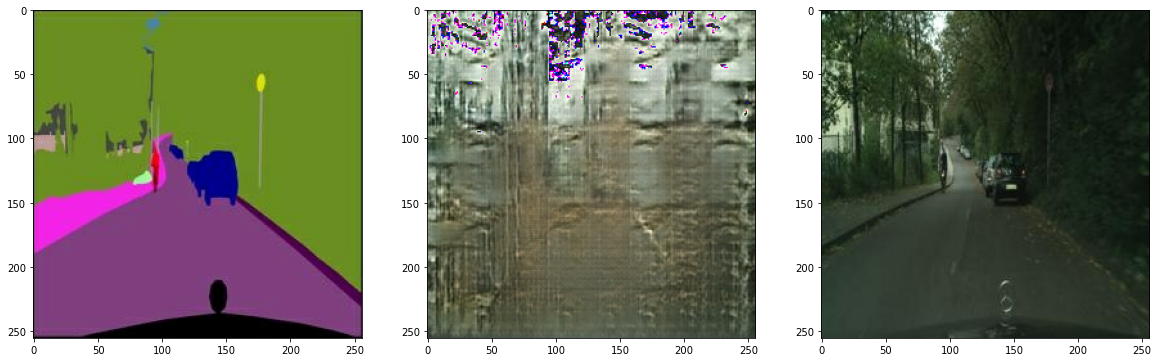

In [50]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(colored))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(sketch))

In [52]:
from glob import glob
val_paths = glob(os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/cityscapes/val/*')
val_paths

['/home/aiffel-dj51/aiffel/conditional_generation/cityscapes/cityscapes/val/5.jpg',
 '/home/aiffel-dj51/aiffel/conditional_generation/cityscapes/cityscapes/val/2.jpg',
 '/home/aiffel-dj51/aiffel/conditional_generation/cityscapes/cityscapes/val/4.jpg',
 '/home/aiffel-dj51/aiffel/conditional_generation/cityscapes/cityscapes/val/1.jpg',
 '/home/aiffel-dj51/aiffel/conditional_generation/cityscapes/cityscapes/val/3.jpg']

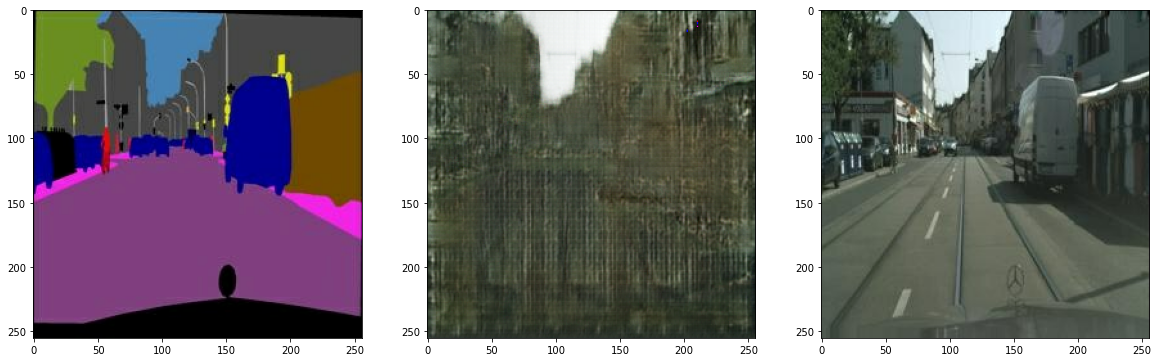

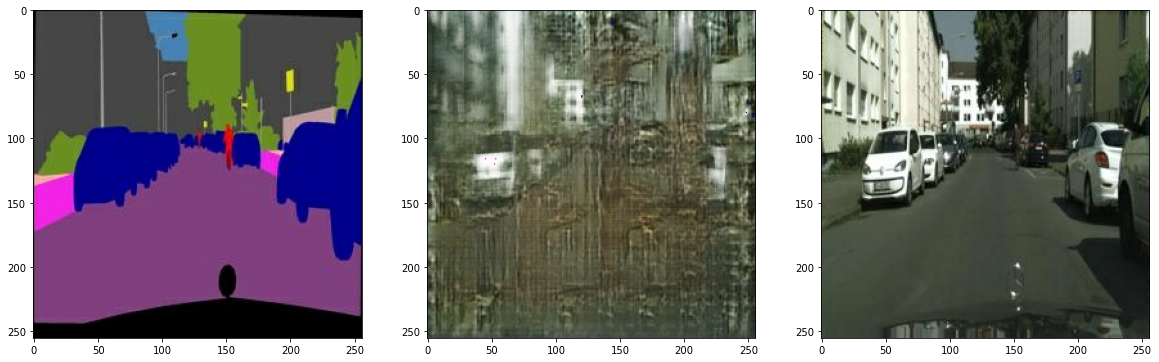

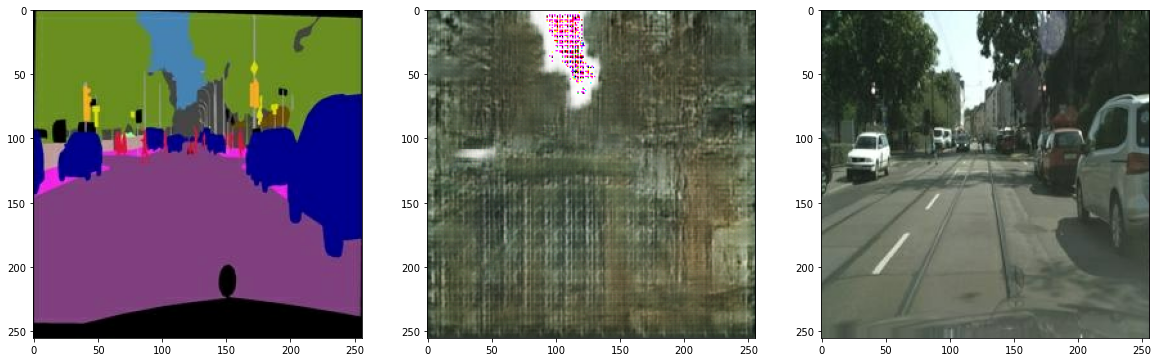

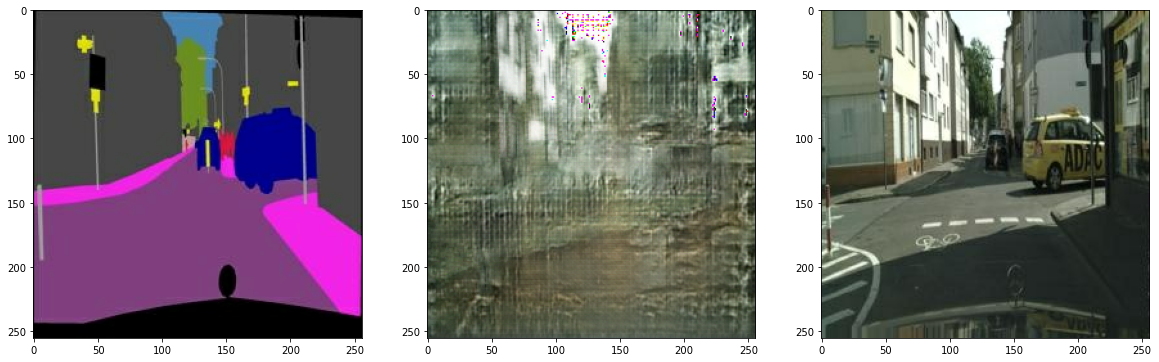

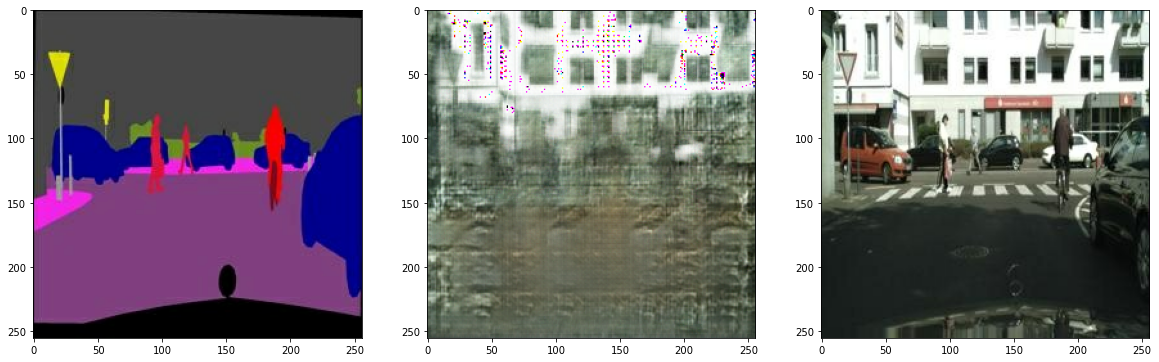

In [53]:
from PIL import Image
for path in val_paths :
    sketch, colored = load_img(path)
    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(colored))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(sketch))
    plt.show()

### 느낀점(회고)

50 epoch 학습하였다:10 epoch에 비해서는 훨씬 좋아졌지만 여전히 조금 아쉬운 결과물이다. 